# Low-thrust transfers via indirect methods

Let us consider the motion of a spacecraft in a central gravity field and in Cartesian coordinates:

In [46]:
import pykep as pk
import numpy as np
import heyoka as hy
import pygmo as pg
import pygmo_plugins_nonfree as ppnf

from matplotlib import pyplot as plt

Parameters are as follow: $[\mu, c_1, c_2, \epsilon, \lambda_0]$, $c_1 = T_{max}$, $c_2 = \frac{T_{max}}{I_{sp}g_0}$

In [47]:
# The state
x, y, z, vx, vy, vz, m = hy.make_vars("x", "y", "z", "vx", "vy", "vz", "m")
# The costate
lx, ly, lz, lvx, lvy, lvz, lm = hy.make_vars(
    "lx", "ly", "lz", "lvx", "lvy", "lvz", "lm"
)
# The controls
u, ix, iy, iz = hy.make_vars("u", "ix", "iy", "iz")

# Useful expressions
r3 = (x**2 + y**2 + z**2) ** (1.5)
lv_norm = hy.sqrt(lvx**2 + lvy**2 + lvz**2)
rho = 1 - hy.par[1] * lv_norm / m / hy.par[4] - hy.par[2] * lm / hy.par[4]

# Vectors for convenience of math manipulation
lr = np.array([lx, ly, lz])
lv = np.array([lvx, lvy, lvz])
r = np.array([x, y, z])
v = np.array([vx, vy, vz])
i_vers = np.array([ix, iy, iz])

# # Hamiltonian
H_full = (
      lr @ v
    + lv @ (hy.par[1] * u / m * i_vers - (hy.par[0] / r3) * r)
    - lm * hy.par[2] * u
    + hy.par[4] * (u - hy.par[3] * hy.log(u*(1 - u)))
)

# Augmented equations of motion
rhs = [
    hy.diff(H_full, var)
    for var in [lx, ly, lz, lvx, lvy, lvz, lm, x, y, z, vx, vy, vz, m]
]
for j in range(7, 14):
    rhs[j] = -rhs[j]

# We apply Pontryagin minimum principle (primer vector and u^* = 2eps / (rho + 2eps + sqrt(rho^2+4*eps^2)))
argmin_H_full = {
    ix: -lvx / lv_norm,
    iy: -lvy / lv_norm,
    iz: -lvz / lv_norm,
    u: 2
    * hy.par[3]
    / (rho + 2 * hy.par[3] + hy.sqrt(rho * rho + 4 * hy.par[3] * hy.par[3])),
}
rhs = hy.subs(rhs, argmin_H_full)

# We also build the Hamiltonian as a function of the state / co-state only
# (i.e. no longer of controls)
H = hy.subs(H_full, argmin_H_full)

# We compile the Hamiltonian into a C function (to be called with pars = [mu, c1, c2, eps, l0])
H_func = hy.cfunc([H], [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm])
# We compile the thrust direction
u_func = hy.cfunc([argmin_H_full[u]], [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm])
# We compile also the thrust direction
i_vers_func = hy.cfunc([argmin_H_full[ix], argmin_H_full[iy], argmin_H_full[iz]], [lvx, lvy, lvz])

In [48]:
full_state = [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm]
sys = [(var, dvar) for var, dvar in zip (full_state, rhs)]
ta = hy.taylor_adaptive(sys, state=[1.]*14)

In [58]:
# Testcase 1
posvel0 = [
    [34110913367.783306, -139910016918.87585, -14037825669.025244],
    [29090.9902134693, 10000.390168313803, 1003.3858682643288],
]
posvelf = [
    [-159018773159.22266, -18832495968.945133, 15781467087.350443],
    [2781.182556622003, -28898.40730995848, -483.4533989771214],
]

tof = 250
mu = pk.MU_SUN


In [66]:
class indirect:
    # x = [lx,ly,lz,lvx,lvy,lvz,lm,l0]
    def __init__(
        self,
        posvel0=posvel0,
        posvelf=posvelf,
        tof=tof,
        mu=mu,
        eps=1e-6,
        T_max=0.6,
        Isp=3000,
        m0=1500,
        L = pk.AU,
        TIME = pk.YEAR2DAY * pk.DAY2SEC,
        MASS = 1500
    ):
        # Non-dimensional units
        VEL = L / TIME # Unit for velocity (1 AU/year)
        ACC = VEL / TIME # Unit for acceleration (1 AU/year^2)
        
        # We redefine the user inputs in non dimensional units
        self.mu = mu / (L**3/TIME**2)
        self.eps = eps
        self.c1 = T_max / (MASS * ACC)
        self.c2 = (T_max / Isp / pk.G0) / MASS * TIME
        
        self.posvel0 = [[it/L for it in posvel0[0]],[it/VEL for it in posvel0[1]]]
        self.posvelf = [[it/L for it in posvelf[0]],[it/VEL for it in posvelf[1]]]

        
        self.m0 = m0 / MASS

        self.tof = tof * pk.DAY2SEC / TIME

    def get_bounds(self):
        lb = [-1.] * 7 + [0.]
        ub = [1.] * 8
        return [lb, ub]

    def set_ta_state(self, x):
        # Preparing the numerical integration parameters
        ta.pars[0] = self.mu
        ta.pars[1] = self.c1
        ta.pars[2] = self.c2
        ta.pars[3] = self.eps
        ta.pars[4] = x[7]
        ta.time = 0.

        # And initial conditions
        ta.state[:3] = self.posvel0[0]
        ta.state[3:6] = self.posvel0[1]
        ta.state[6] = self.m0
        ta.state[7:14] = x[:7]

    def fitness(self, x):
        # Single Shooting
        self.set_ta_state(x)
        ta.propagate_until(self.tof)
        # Assembling the constraints
        ceq = [(ta.state[0] - self.posvelf[0][0]) ]
        ceq += [(ta.state[1] - self.posvelf[0][1]) ]
        ceq += [(ta.state[2] - self.posvelf[0][2]) ]
        ceq += [(ta.state[3] - self.posvelf[1][0]) ]
        ceq += [(ta.state[4] - self.posvelf[1][1]) ]
        ceq += [(ta.state[5] - self.posvelf[1][2]) ]
        ceq += [ta.state[13]]  # lm = 0
        ceq += [(np.linalg.norm(x) - 1.)]  # |lambdas| = 1
        return [1.0] + ceq

    def get_nec(self):
        return 8
    
    def plot(self, x, N=100):
        # Single Shooting
        self.set_ta_state(x)
        t_grid = np.linspace(0, self.tof_in_secs,N)
        sol = ta.propagate_grid(t_grid)
        ax3D = pk.plot.make_3Daxis()
        pk.plot.add_sun(ax3D)
        pk.plot(sol[-1][:,0], sol[-1][:,1], sol[-1][:,2])
        return ax3D

In [67]:
udp = indirect()
prob = pg.problem(udp)
prob.c_tol = 1e-6

In [68]:
snopt72 = "/Users/dario.izzo/opt/libsnopt7_c.dylib"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
# uda.set_integer_option("Major iterations limit", 2000)
# uda.set_integer_option("Iterations limit", 20000)

uda.set_numeric_option("Major iterations limit", 500)
uda.set_numeric_option("Superbasics", 1500)

uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-11)

#uda = pg.nlopt("slsqp")
algo = pg.algorithm(uda)

In [69]:
masses = []
xs = []
for i in range(50):
    pop = pg.population(prob, 1)
    pop = algo.evolve(pop)
    if(prob.feasibility_f(pop.champion_f)):
        print(".", end="")
        udp.fitness(pop.champion_x)
        masses.append(ta.state[6] * 1500)
        xs.append(pop.champion_x)
        break
    else:
        print("x", end ="")

.

<Axes3D: >

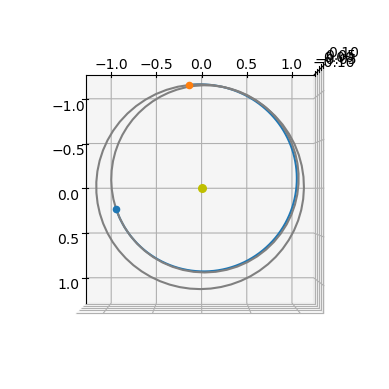

In [70]:
# Single Shooting
udp.set_ta_state(pop.get_x()[0])
t_grid = np.linspace(0, udp.tof,100)
sol = ta.propagate_grid(t_grid)
ax3D = pk.plot.make_3Daxis()
pk.plot.add_sun(ax3D)
ax3D.plot(sol[-1][:,0], sol[-1][:,1], sol[-1][:,2])
ax3D.view_init(90,0)
ax3D.scatter(udp.posvel0[0][0], udp.posvel0[0][1], udp.posvel0[0][2])
ax3D.scatter(udp.posvelf[0][0], udp.posvelf[0][1], udp.posvelf[0][2])
pl1 = pk.planet(pk.udpla.keplerian(when = pk.epoch(0), posvel=posvel0, mu_central_body=pk.MU_SUN))
pl2 = pk.planet(pk.udpla.keplerian(when = pk.epoch(0), posvel=posvelf, mu_central_body=pk.MU_SUN))
pk.plot.add_planet_orbit(ax3D, pl1, c='gray', units=pk.AU)
pk.plot.add_planet_orbit(ax3D, pl2, c='gray', units=pk.AU)

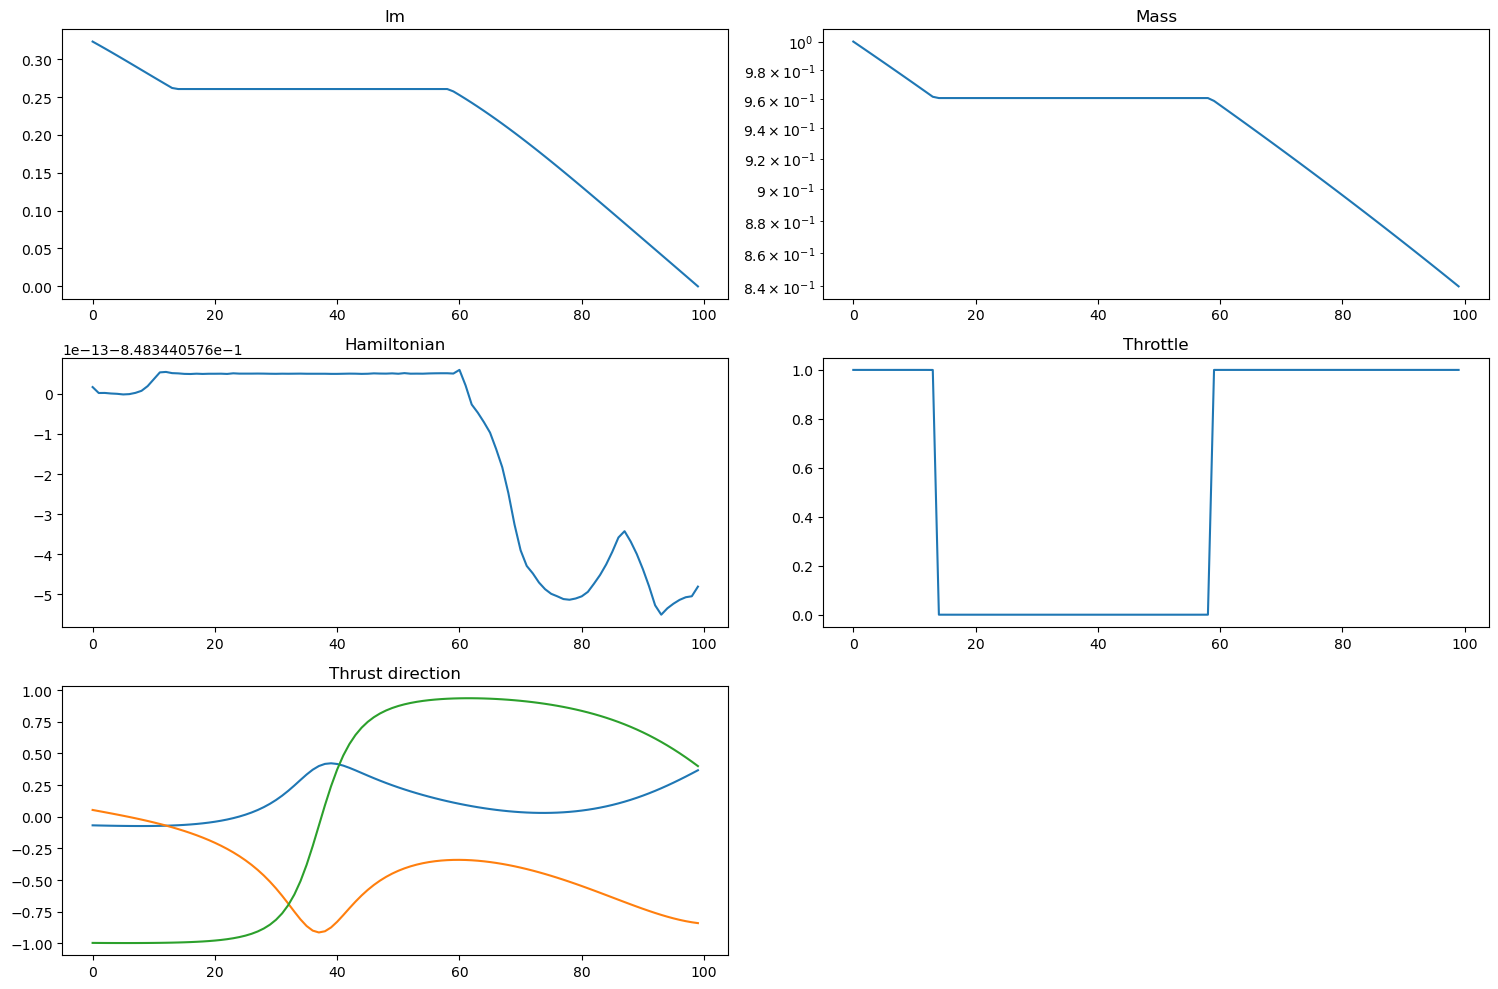

In [72]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))

axs[0, 0].set_title("lm")
axs[0, 0].plot(sol[-1][:, 13].T)

axs[0, 1].set_title("Mass")
axs[0, 1].semilogy(sol[-1][:, 6].T)

Ham = H_func(np.ascontiguousarray(sol[-1].T), pars=np.ascontiguousarray(np.tile(ta.pars, (100, 1)).T))
axs[1, 0].set_title("Hamiltonian")
axs[1, 0].plot(np.squeeze(Ham))

thrust = u_func(np.ascontiguousarray(sol[-1].T), pars=np.ascontiguousarray(np.tile(ta.pars, (100, 1)).T))
axs[1, 1].set_title("Throttle")
axs[1, 1].plot(np.squeeze(thrust))

thrust_dir = i_vers_func(np.ascontiguousarray(sol[-1][:, 10:13].T))
for i in range(3):
    axs[2, 0].plot(thrust_dir[i, :])
axs[2, 0].set_title("Thrust direction")

fig.delaxes(axs[2, 1])  # Remove the empty subplot

plt.tight_layout()
plt.show()

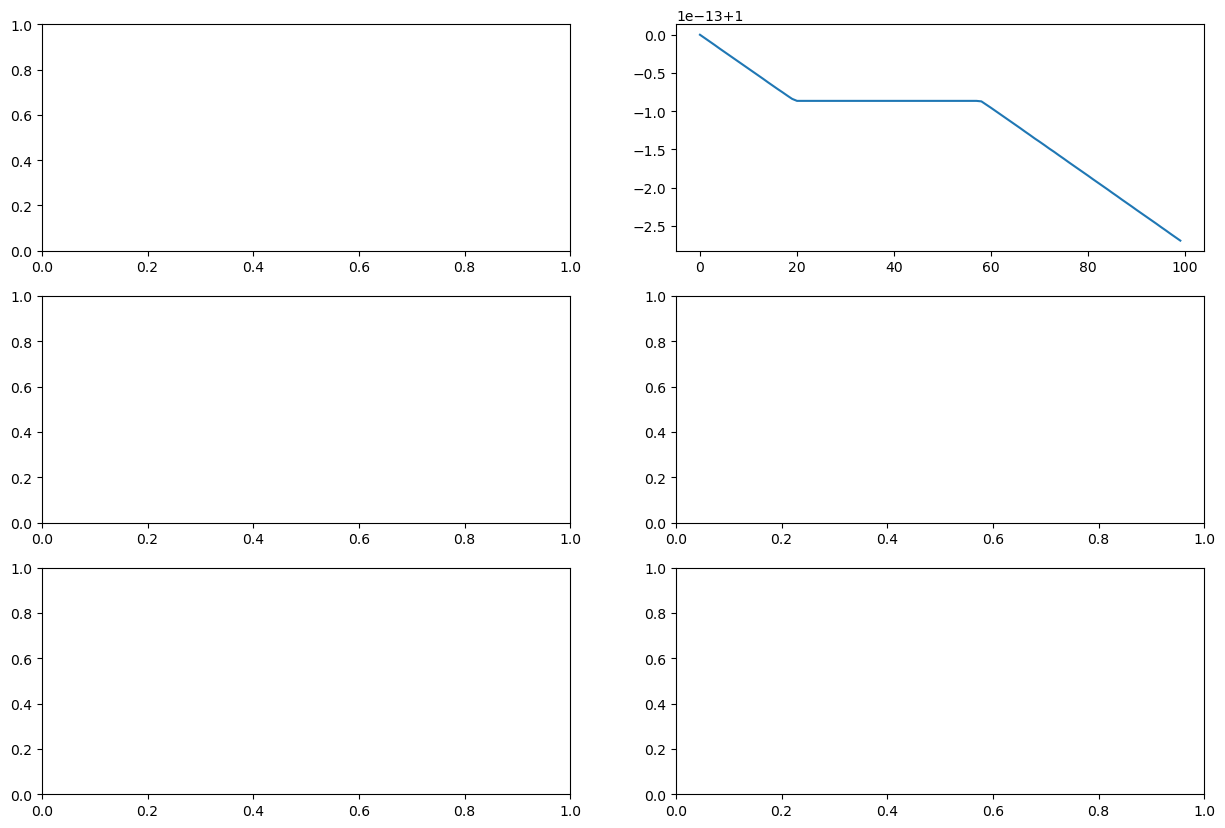

In [36]:
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
axs[0, 1].plot(sol[-1][:, 6].T)